## Detect Timeseries Anomalies 

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

### Imports

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

### Aquire Data

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [3]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   status          13974 non-null  int64 
 4   size            13974 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13974 non-null  object
dtypes: int64(2), object(5)
memory usage: 764.3+ KB


In [4]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


### Prep Data

In [5]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')
    
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex = True)

df[['request_call','api_version','endpoints','http']] = \
    df.request_method.str.extract(r'(?P<request_call>^[A-Z]+)\s(?P<api_version>\/api\/v[0-9])(?P<endpoints>.+)(?P<http_version>HTTP\/[0-9]\.[0-9])', expand = True)

df['size_mb'] = [n/1024/1024 for n in df['size']]



In [6]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').max()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

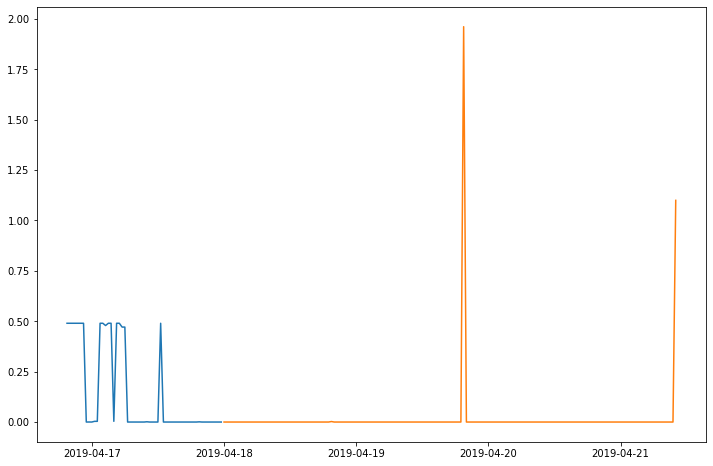

In [7]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:30:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

In [8]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()

TypeError: float() argument must be a string or a number, not 'Timestamp'

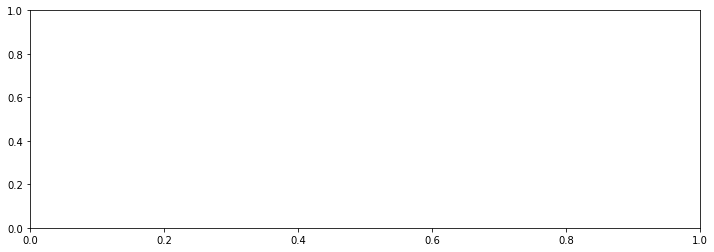

In [9]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [ ]:
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short.tail()

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [ ]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

pct_b = pd.DataFrame({'pct_b': (train-lb)/(ub-lb)})
train = pd.DataFrame(train)

train = pd.concat([train, pct_b], axis=1)

train.head()


In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train.pct_b)
plt.plot(train.size_mb)

## Bonus

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What are Zach, Maggie, Faith, and Ryan's ids?